# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [116]:
# import libraries
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, FloatType, LongType, DoubleType
import pyspark.sql.functions as F
from pyspark.ml import Transformer, Pipeline, Estimator
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param
from pyspark.ml.feature import StringIndexer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

import pandas as pd

In [2]:
# create a Spark session
spark = SparkSession \
        .builder \
        .appName("sparkify") \
        .master("spark://Y4309353:7077") \
        .config("spark.executor.memory", "14G") \
        .getOrCreate()

"""
configure = SparkConf() \
    .setAppName("sparkify") \
    .setMaster("spark://Y4309353:7077")
sc = SparkContext(conf=configure)
"""

'\nconfigure = SparkConf()     .setAppName("sparkify")     .setMaster("spark://Y4309353:7077")\nsc = SparkContext(conf=configure)\n'

In [3]:
# Constants
MINI_DATA = "mini_sparkify_event_data.json"
# BIG_DATA = 

DATA = MINI_DATA

MAX_ROWS = 300000

# Load and Clean Dataset
Clean your dataset, checking for invalid or missing data. For example, records without userids or sessionids. In this workspace, the filename is `mini_sparkify_event_data.json`.

In [4]:
data = spark.read.json(DATA)

In [5]:
data.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [6]:
n_rows = data.count()
n_rows

286500

In [7]:
len(data.columns)

18

In [8]:
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [9]:
data.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [10]:
data.select(*(F.sum(F.col(c).isNull().cast("int")).alias(c) for c in data.columns)).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [11]:
# Let's analyze how many rows with null values are there
data.dropna().count() / n_rows

0.7961884816753927

So, about 20% of the rows have some missing data. What about the columns?

In [12]:
data.select([F.count(F.when(F.isnan(c), c)).alias(c) for c in data.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [13]:
data.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [14]:
# Using pandas for a better presentation of the results
res = data.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in data.columns])
pd_res = res.toPandas().iloc[0].sort_values(ascending=False)
pd_res

artist           58392
song             58392
length           58392
userAgent         8346
firstName         8346
gender            8346
lastName          8346
location          8346
registration      8346
method               0
page                 0
level                0
sessionId            0
itemInSession        0
status               0
ts                   0
auth                 0
userId               0
Name: 0, dtype: int64

In [15]:
pd_res / n_rows

artist           0.203812
song             0.203812
length           0.203812
userAgent        0.029131
firstName        0.029131
gender           0.029131
lastName         0.029131
location         0.029131
registration     0.029131
method           0.000000
page             0.000000
level            0.000000
sessionId        0.000000
itemInSession    0.000000
status           0.000000
ts               0.000000
auth             0.000000
userId           0.000000
Name: 0, dtype: float64

So, there are about 20% of cases in which the song features are missing, and about 3% of cases in which the user data is missing. Those cases probably have an explaination...

In [16]:
# Get a sample and analyze it in Pandas. N_sample = 300000
N_SAMPLES = 300000.0  # This number will cover the entire mini dataset, but no the big one
n_rows = data.count()
fraction = min(N_SAMPLES / n_rows, 1.0)

pdata = data.sample(withReplacement=False,
                    fraction=fraction,
                    seed=42).toPandas()
print(pdata.shape)
pdata.head()

(286500, 18)


,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [17]:
pdata.isnull().sum().sort_values(ascending=False)

artist           58392
song             58392
length           58392
userAgent         8346
firstName         8346
gender            8346
lastName          8346
location          8346
registration      8346
method               0
page                 0
level                0
sessionId            0
itemInSession        0
status               0
ts                   0
auth                 0
userId               0
dtype: int64

In [18]:
pdata.loc[pdata.isnull().any(axis=1), :].head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1.538173e+12,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
11,None,Logged In,Micah,M,84,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",GET,Roll Advert,1.538332e+12,8,None,200,1538353150000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
14,None,Logged In,Micah,M,86,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",PUT,Thumbs Up,1.538332e+12,8,None,307,1538353376000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
35,None,Logged In,Alexi,F,4,Warren,NaN,paid,"Spokane-Spokane Valley, WA",GET,Downgrade,1.532483e+12,53,None,200,1538354749000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54
44,None,Logged In,Alexi,F,7,Warren,NaN,paid,"Spokane-Spokane Valley, WA",PUT,Thumbs Up,1.532483e+12,53,None,307,1538355255000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54


There is always a sessionId and a userID

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [19]:
pdata.page.unique()

array(['NextSong', 'Add to Playlist', 'Roll Advert', 'Thumbs Up',
       'Downgrade', 'Thumbs Down', 'Home', 'Logout', 'Help', 'Login',
       'Upgrade', 'Add Friend', 'About', 'Settings', 'Submit Upgrade',
       'Submit Downgrade', 'Error', 'Save Settings', 'Cancel',
       'Cancellation Confirmation', 'Register', 'Submit Registration'],
      dtype=object)

In [20]:
(pdata.page == 'Cancellation Confirmation').sum()

52

In [21]:
(pdata.page == 'Cancellation Confirmation').mean()

0.00018150087260034904

In [22]:
(pdata.page == 'Downgrade').sum()

2055

In [23]:
pdata.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


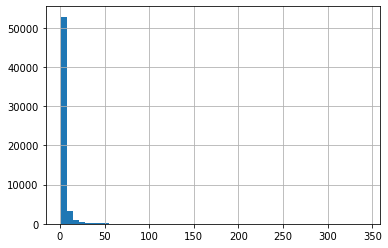

In [24]:
pdata.groupby('song').itemInSession.nunique().hist(bins=50)

OK, I don't really know what "itemInSession" means.

In [25]:
user_cols = ['userId', 'registration', 'location', 'firstName', 'lastName', 'gender']  # Those that look like "static" features of the user
song_cols = ['artist', 'length', 'song']
other_cols = ['itemInSession', 'auth', 'level', 'method', 'page', 'sessionId',
              'status', 'ts', 'userAgent']

In [26]:
pdata.shape[1] == len(user_cols) + len(song_cols) + len(other_cols)

True

In [27]:
(pdata.length / 60).describe()

count    228108.000000
mean          4.151953
std           1.653920
min           0.013054
25%           3.331476
50%           3.908346
75%           4.619312
max          50.411094
Name: length, dtype: float64

That is clearly the length of the song.

## User Info

In [28]:
pdata[user_cols].head()

,userId,registration,location,firstName,lastName,gender
0,30,1.538173e+12,"Bakersfield, CA",Colin,Freeman,M
1,9,1.538332e+12,"Boston-Cambridge-Newton, MA-NH",Micah,Long,M
2,30,1.538173e+12,"Bakersfield, CA",Colin,Freeman,M
3,9,1.538332e+12,"Boston-Cambridge-Newton, MA-NH",Micah,Long,M
4,30,1.538173e+12,"Bakersfield, CA",Colin,Freeman,M


In [29]:
pdata[user_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286500 entries, 0 to 286499
Data columns (total 6 columns):
userId          286500 non-null object
registration    278154 non-null float64
location        278154 non-null object
firstName       278154 non-null object
lastName        278154 non-null object
gender          278154 non-null object
dtypes: float64(1), object(5)
memory usage: 13.1+ MB


It looks like there may be some numeric columns defined as "object"

In [30]:
pdata.userId.nunique()

226

In [31]:
pdata.userId.unique()

array(['30', '9', '74', '54', '', '4', '101', '78', '88', '95', '25',
       '142', '13', '45', '39', '87', '28', '131', '126', '146', '59',
       '15', '36', '120', '92', '33', '51', '27', '143', '140', '6',
       '124', '141', '93', '81', '40', '94', '113', '98', '137', '65',
       '53', '42', '115', '38', '58', '77', '52', '29', '70', '61', '46',
       '35', '132', '127', '136', '80', '110', '129', '121', '82', '100',
       '117', '18', '85', '118', '105', '96', '20', '55', '3', '12', '41',
       '73', '17', '86', '7', '67', '32', '5', '106', '114', '69', '99',
       '16', '49', '50', '24', '103', '102', '122', '75', '135', '128',
       '111', '112', '145', '66', '83', '44', '11', '91', '37', '90',
       '104', '138', '148', '107', '97', '109', '134', '10', '2', '144',
       '76', '119', '89', '14', '62', '19', '150', '68', '147', '8', '56',
       '34', '60', '125', '47', '133', '26', '43', '57', '149', '64',
       '21', '71', '108', '79', '123', '116', '152', '63', '139

There are some empty strings, to take into account, and the userID values have a strange pattern. There are some very big numbers, and then a lot of small ones.

In [32]:
pdata.userId.value_counts()

39        9632
          8346
92        7230
140       6880
300011    5732
          ... 
300003      35
100011      23
125         11
135          6
156          6
Name: userId, Length: 226, dtype: int64

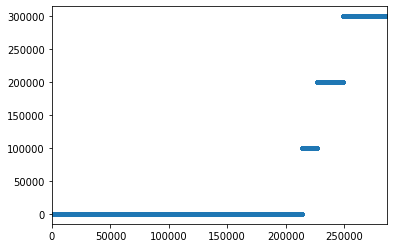

In [33]:
pd.to_numeric(pdata.userId).plot(style='.')

In [34]:
pd.to_numeric(pdata.userId).unique()

array([3.00000e+01, 9.00000e+00, 7.40000e+01, 5.40000e+01,         nan,
       4.00000e+00, 1.01000e+02, 7.80000e+01, 8.80000e+01, 9.50000e+01,
       2.50000e+01, 1.42000e+02, 1.30000e+01, 4.50000e+01, 3.90000e+01,
       8.70000e+01, 2.80000e+01, 1.31000e+02, 1.26000e+02, 1.46000e+02,
       5.90000e+01, 1.50000e+01, 3.60000e+01, 1.20000e+02, 9.20000e+01,
       3.30000e+01, 5.10000e+01, 2.70000e+01, 1.43000e+02, 1.40000e+02,
       6.00000e+00, 1.24000e+02, 1.41000e+02, 9.30000e+01, 8.10000e+01,
       4.00000e+01, 9.40000e+01, 1.13000e+02, 9.80000e+01, 1.37000e+02,
       6.50000e+01, 5.30000e+01, 4.20000e+01, 1.15000e+02, 3.80000e+01,
       5.80000e+01, 7.70000e+01, 5.20000e+01, 2.90000e+01, 7.00000e+01,
       6.10000e+01, 4.60000e+01, 3.50000e+01, 1.32000e+02, 1.27000e+02,
       1.36000e+02, 8.00000e+01, 1.10000e+02, 1.29000e+02, 1.21000e+02,
       8.20000e+01, 1.00000e+02, 1.17000e+02, 1.80000e+01, 8.50000e+01,
       1.18000e+02, 1.05000e+02, 9.60000e+01, 2.00000e+01, 5.500

to_numeric converts the '' to nan.

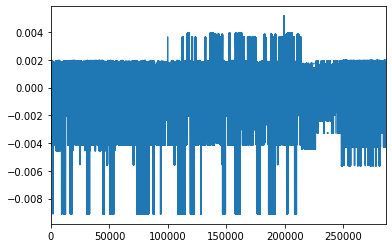

In [35]:
((pdata.registration - pdata.registration.mean()) / pdata.registration.mean()).plot()

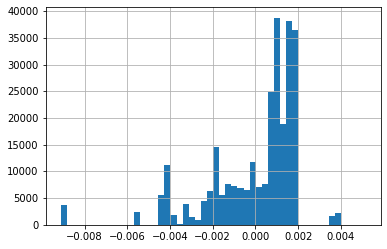

In [36]:
((pdata.registration - pdata.registration.mean()) / pdata.registration.mean()).hist(bins=50)

No huge outliers. The newer users could be a bit strange though... Are those the ones with the strange userId's?

In [37]:
to_float = F.udf(lambda x: np.nan if x == '' else float(x), FloatType())

In [38]:
to_int = F.udf(lambda x: int(x), IntegerType())

In [39]:
data.sample(False, fraction, 42).filter(data.userId != '').toPandas().userId.nunique()

225

In [40]:
data_sample = data.sample(False, fraction, 42)

In [41]:
# Convert userId to numeric
data = data.filter(data.userId != '')
data = data.withColumn('userId', to_int(data.userId))

In [42]:
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: integer (nullable = true)



In [47]:
data[['userId']].show(10)

+------+
|userId|
+------+
|    30|
|     9|
|    30|
|     9|
|    30|
|     9|
|     9|
|    30|
|    30|
|    30|
+------+
only showing top 10 rows



In [44]:
pdd = data.toPandas()

In [79]:
pdd.dtypes

artist            object
auth              object
firstName         object
gender            object
itemInSession      int64
lastName          object
length           float64
level             object
location          object
method            object
page              object
registration       int64
sessionId          int64
song              object
status             int64
ts                 int64
userAgent         object
userId             int32
dtype: object

### location

In [80]:
pdata.location.nunique()

114

There are 114 different locations. Let's label encode those. There could be some geographic features generated, but that would be later.

### first_name

In [83]:
pdata.firstName.nunique()

189

Again, let's label encode

In [84]:
pdata.lastName.nunique()

173

Label encode that.

In [87]:
to_int = F.udf(lambda x: int(x), LongType())

class UserIdNumeric(Transformer):
    """ Drops missing userIds and transforms them to integer."""
    def transform(self, data):
        result = data.filter(data.userId != '') \
                     .withColumn('userId', to_int(data.userId))
        return result

## Let's test a pipeline with just that filter

In [88]:
basic_pipeline = Pipeline(stages=[UserIdNumeric()])

In [89]:
data = spark.read.json(DATA)

In [90]:
basic_pipeline_model = basic_pipeline.fit(data)
data2 = basic_pipeline_model.transform(data)

In [91]:
data2.dtypes

[('artist', 'string'),
 ('auth', 'string'),
 ('firstName', 'string'),
 ('gender', 'string'),
 ('itemInSession', 'bigint'),
 ('lastName', 'string'),
 ('length', 'double'),
 ('level', 'string'),
 ('location', 'string'),
 ('method', 'string'),
 ('page', 'string'),
 ('registration', 'bigint'),
 ('sessionId', 'bigint'),
 ('song', 'string'),
 ('status', 'bigint'),
 ('ts', 'bigint'),
 ('userAgent', 'string'),
 ('userId', 'bigint')]

### Now a pipeline that preprocesses the full user info

In [143]:
class MyStringIndexer(Estimator):
    def __init__(self, col_names):
        super().__init__()
        self.col_names = col_names
        self.pipe = Pipeline(stages=[
            StringIndexer(inputCol=c, outputCol=c + '_idx') 
            for c in self.col_names])
        self.model = None
    
    def fit(self, data):
        self.model = self.pipe.fit(data)
        return self
    
    def transform(self, data):
        result = self.model.transform(data)
        col_renames = [F.col(c + '_idx').alias(c) if c in self.col_names
                       else F.col(c) for c in data.columns]
        result = result.drop(*self.col_names).select(col_renames)
        return result

In [144]:
user_pipeline = Pipeline(stages=[
    UserIdNumeric(),
    MyStringIndexer(['location', 'firstName', 'lastName', 'gender']),
])

In [145]:
up_model = user_pipeline.fit(data)
data2 = up_model.transform(data)

In [147]:
data2.dtypes

[('artist', 'string'),
 ('auth', 'string'),
 ('firstName', 'double'),
 ('gender', 'double'),
 ('itemInSession', 'bigint'),
 ('lastName', 'double'),
 ('length', 'double'),
 ('level', 'string'),
 ('location', 'double'),
 ('method', 'string'),
 ('page', 'string'),
 ('registration', 'bigint'),
 ('sessionId', 'bigint'),
 ('song', 'string'),
 ('status', 'bigint'),
 ('ts', 'bigint'),
 ('userAgent', 'string'),
 ('userId', 'bigint')]

In [150]:
data2.toPandas()[user_cols].head()

,userId,registration,location,firstName,lastName,gender
0,30,1538173362000,51.0,6.0,58.0,1.0
1,9,1538331630000,2.0,22.0,19.0,1.0
2,30,1538173362000,51.0,6.0,58.0,1.0
3,9,1538331630000,2.0,22.0,19.0,1.0
4,30,1538173362000,51.0,6.0,58.0,1.0


## Song Info

In [152]:
song_data = pdata[song_cols]
print(song_data.shape)
song_data.head()

(286500, 3)


,artist,length,song
0,Martha Tilston,277.89016,Rockpools
1,Five Iron Frenzy,236.09424,Canada
2,Adam Lambert,282.82730,Time For Miracles
3,Enigma,262.71302,Knocking On Forbidden Doors
4,Daft Punk,223.60771,Harder Better Faster Stronger


In [153]:
song_data.dtypes

artist     object
length    float64
song       object
dtype: object

In [155]:
song_data.artist.value_counts()

Kings Of Leon                1841
Coldplay                     1813
Florence + The Machine       1236
Dwight Yoakam                1135
BjÃÂ¶rk                     1133
                             ... 
OutKast featuring Raekwon       1
Barrio Jazz Gang                1
Bill Laswell                    1
Johnny Van Zandt                1
Javier Ruibal                   1
Name: artist, Length: 17655, dtype: int64

In [156]:
song_data.artist.nunique()

17655

Too many to one-hot encode. Let's label encode.

In [157]:
song_data.song.nunique()

58480

Same thing as before...

### Missing data in song columns

In [158]:
song_data.isnull().sum()

artist    58392
length    58392
song      58392
dtype: int64

Let's encode those as -1

## Other Info

### status

In [46]:
pdata.status.unique()

array([200, 307, 404])

Those are clearly HTML codes.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.